📁 Ditemukan 2179 gambar dari 5 kelas.



C:\Users\Raga Triagantara\AppData\Local\Temp\ipykernel_1552\1033406439.py:78: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Proses 20/2179 gambar...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s

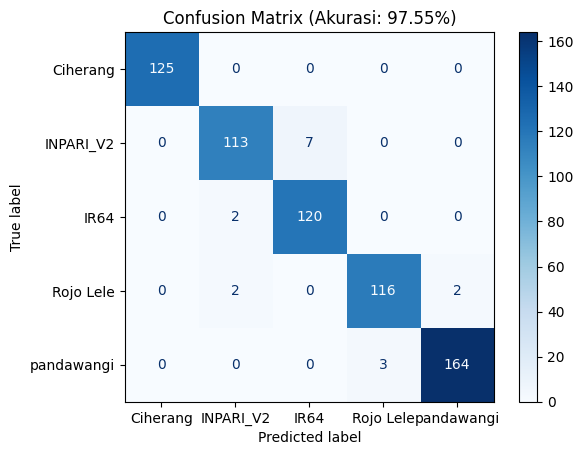

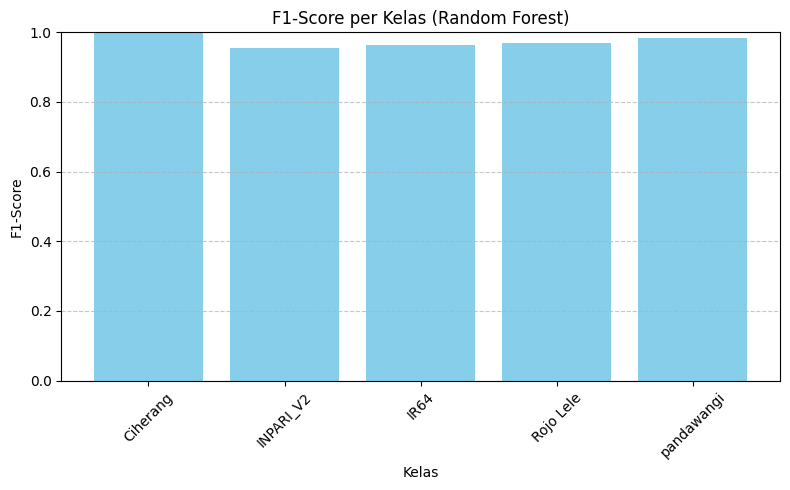

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.feature import graycomatrix, graycoprops
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# === 1. Path dataset ===
folder_path = r"C:\Users\Raga Triagantara\Archives\Projects\Program GLCM\GABAH"

# === 2. Ambil semua gambar dari subfolder ===
image_files = []
labels = []
for root, _, files in os.walk(folder_path):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.jfif')):
            image_files.append(os.path.join(root, f))
            labels.append(os.path.basename(root))  # nama folder = label kelas

if len(image_files) == 0:
    print(f"❌ Tidak ada gambar di folder: {folder_path}")
    raise SystemExit

print(f"📁 Ditemukan {len(image_files)} gambar dari {len(set(labels))} kelas.\n")

# === 3. Definisi fungsi tambahan ===
def gray_world_normalization(img):
    B, G, R = cv2.split(img.astype(np.float32))
    mean_R, mean_G, mean_B = np.mean(R), np.mean(G), np.mean(B)
    mean_gray = (mean_R + mean_G + mean_B) / 3
    R = np.clip(R * (mean_gray / mean_R), 0, 255)
    G = np.clip(G * (mean_gray / mean_G), 0, 255)
    B = np.clip(B * (mean_gray / mean_B), 0, 255)
    return cv2.merge([B, G, R]).astype(np.uint8)

def otsu_threshold(hist):
    sum_total = np.dot(np.arange(256), hist)
    best_t, max_sigma = 0, 0
    w0, sum0 = 0.0, 0.0
    for t in range(256):
        w0 += hist[t]
        sum0 += t * hist[t]
        if w0 == 0 or w0 == 1:
            continue
        w1 = 1 - w0
        mu0 = sum0 / w0
        mu1 = (sum_total - sum0) / w1
        sigma_b = w0 * w1 * (mu0 - mu1) ** 2
        if sigma_b > max_sigma:
            max_sigma, best_t = sigma_b, t
    return best_t

def glcm_features(image):
    levels = 64
    image_scaled = (image / 256 * levels).astype(np.uint8)
    glcm = graycomatrix(image_scaled,
                        distances=[1],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=levels,
                        symmetric=True,
                        normed=True)
    features = {
        "contrast": graycoprops(glcm, 'contrast').mean(),
        "correlation": graycoprops(glcm, 'correlation').mean(),
        "energy": graycoprops(glcm, 'energy').mean(),
        "homogeneity": graycoprops(glcm, 'homogeneity').mean()
    }
    return features

# === 4. Load MobileNetV2 untuk ekstraksi fitur ===
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image as tf_image

base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
base_model.trainable = False  # Freeze model

def extract_mobilenet_features(img):
    img_resized = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    x = tf_image.img_to_array(img_rgb)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = base_model.predict(x)
    return features.flatten()

# === 5. Dummy Capsule Network Feature Extractor ===
# Karena CapsNet kompleks, kita gunakan placeholder untuk ekstraksi fitur alternatif
def extract_capsnet_features(img):
    # Placeholder: gunakan flatten dari gambar untuk simulasi
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (64, 64))
    return img_resized.flatten() / 255.0  # Normalisasi

# === 6. Ekstraksi Fitur Gabungan ===
kernel = np.ones((3, 3), np.uint8)
data = []

for i, (img_path, label) in enumerate(zip(image_files, labels)):
    file_name = os.path.basename(img_path)
    img_color = cv2.imread(img_path)
    if img_color is None:
        print(f"⚠️ Gagal membaca {file_name}, dilewati.")
        continue

    img_color = cv2.resize(img_color, (256, 256))  # hemat RAM
    img_norm = gray_world_normalization(img_color)
    img_gray = cv2.cvtColor(img_norm, cv2.COLOR_BGR2GRAY)

    # GLCM Features
    hist = cv2.calcHist([img_gray], [0], None, [256], [0, 256])
    hist = hist.ravel() / hist.sum()
    t_otsu = otsu_threshold(hist)
    _, th_otsu = cv2.threshold(img_gray, t_otsu, 255, cv2.THRESH_BINARY)
    th_small = cv2.resize(th_otsu, (128, 128))
    glcm_feat = glcm_features(th_small.astype(np.uint8))

    # MobileNet Features
    mobilenet_feat = extract_mobilenet_features(img_color)

    # CapsNet Features (simulasi)
    capsnet_feat = extract_capsnet_features(img_color)

    # Gabungkan semua fitur
    combined_features = np.concatenate([
        list(glcm_feat.values()),
        mobilenet_feat,
        capsnet_feat
    ])

    data.append({
        "features": combined_features,
        "label": label
    })

    if (i + 1) % 20 == 0:
        print(f"Proses {i+1}/{len(image_files)} gambar...")

# === 7. Siapkan dataset untuk Random Forest ===
df = pd.DataFrame(data)
X = np.array(df['features'].tolist())
y = df['label'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# === 8. Train Random Forest ===
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# === 9. Evaluasi ===
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\n✅ Akurasi Random Forest: {acc*100:.2f}%")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# === 10. Plot Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (Akurasi: {acc*100:.2f}%)')
plt.show()

# === 11. Visualisasi Akurasi per Kelas ===
report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T
report = report.drop(index=['accuracy', 'macro avg', 'weighted avg'])

plt.figure(figsize=(8, 5))
plt.bar(report.index, report['f1-score'], color='skyblue')
plt.title("F1-Score per Kelas (Random Forest)")
plt.xlabel("Kelas")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()